Purpose of notebook is to scrape web data on financial asset prices and run a mean-variance optimisation framework to target a specific risk-return profile

Import relevant libraries

In [364]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

Construct URL Generator for given set of securities to import price data

In [365]:
#Provide a dictionary with names and yahoo symbols for securities in portfolio

securities_dictionary ={'S&P 500':'%5EGSPC',
                        'Purpose US Cash ETF' : 'PSU-U.TO'}

#Specify frequency of data download eg. daily = '1d' /monthly = '1mo' /weekly = '1wk'

frequency ='1d'

#Specify time window to download data eg. last 30 days

lookback = 20

#Generates epoch timestamps to construct URL

today_date = dt.datetime(dt.datetime.now().year, dt.datetime.now().month, dt.datetime.now().day,1,0,0)
start_date = today_date - dt.timedelta(days=lookback)

today_date_string = str(round(today_date.timestamp()))
start_date_string = str(round(start_date.timestamp()))

#Creates URL dictionary mapping security names to corresponding URL downloads

url_dictionary = {}

for security in securities_dictionary.keys():
    url ='https://query1.finance.yahoo.com/v7/finance/download/'\
         +securities_dictionary[security]+\
         '?period1='+start_date_string\
         +'&period2='+today_date_string\
         +'&interval='+frequency\
         +'&events=history'
    url_dictionary[security] = url

print(url_dictionary)


{'S&P 500': 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=1592438400&period2=1594166400&interval=1d&events=history', 'Purpose US Cash ETF': 'https://query1.finance.yahoo.com/v7/finance/download/PSU-U.TO?period1=1592438400&period2=1594166400&interval=1d&events=history'}


In [368]:
#Download web data from URL dictionary and store in a dataframe
#Creates a dictionary of dataframes

securities_price_dictionary = {}

for security in url_dictionary.keys():
    #Construct dictionary of dataframes
    securities_price_dictionary[security]=pd.read_csv(url_dictionary[security], parse_dates=True)
    #Select only columns of interest in each dataframe
    securities_price_dictionary[security] = securities_price_dictionary[security][['Date', 'Adj Close']]
    #Relabel columns in each dataframe
    securities_price_dictionary[security].columns = ['Date', security+' price level']
    #Set dates in each dataframe to Datetime objects
    securities_price_dictionary[security]['Date'] = pd.to_datetime(securities_price_dictionary[security]['Date'])

#Generate a dataframe of dataframes for every individual security
securities_price_df = pd.concat(securities_price_dictionary, axis=1)

#Create a dataframe of returns by filtering dataframe of pricing data
securities_return_df = pd.DataFrame()

for security, column in securities_price_df.columns:
    if(securities_price_df[security][column].dtype == 'float64'):
        securities_return_df[security + ' return'] = securities_price_df[security][column].pct_change(fill_method='ffill')
    else:
        securities_return_df['Date'] = securities_price_df[security][column]

securities_return_df = securities_return_df.dropna()
securities_return_df= securities_return_df.set_index('Date')


print(securities_return_df, '\n')

print('Volatility of S&P 500 is', securities_return_df.iloc[:,1].std()*100*np.sqrt(260))

            Purpose US Cash ETF return  S&P 500 return
Date                                                  
2020-06-19                     -0.0001       -0.005649
2020-06-22                      0.0000        0.006495
2020-06-23                      0.0000        0.004307
2020-06-24                      0.0000       -0.025855
2020-06-25                      0.0000        0.010959
2020-06-26                      0.0001       -0.024227
2020-06-29                     -0.0002        0.014686
2020-06-30                      0.0000        0.015410
2020-07-01                      0.0000        0.005022
2020-07-02                      0.0000        0.004541
2020-07-06                      0.0000        0.015882
2020-07-07                      0.0000       -0.010819 

Volatility of S&P 500 is 23.451514964331544


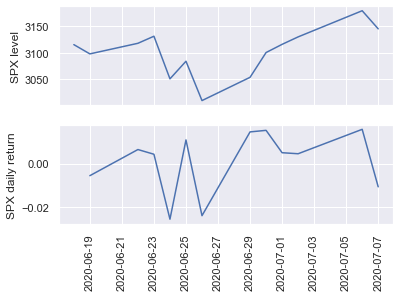

In [390]:
#Plot dataframe to check 

fig, ax = plt.subplots(2, sharex=True)
sns.set()

ax[0].plot('Date', 'S&P 500 price level', data=securities_price_df['S&P 500'])
ax[0].set_ylabel('SPX level')


ax[1].plot(securities_return_df.index, 'S&P 500 return', data=securities_return_df)
ax[1].set_ylabel('SPX daily return')


plt.xticks(rotation=90)
plt.show()
